# No joke

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.optimizers import RMSprop

Using TensorFlow backend.


## Settings

In [2]:
MAX_LEN = 50
MAX_WORDS = 10000
EMBEDDING_DIM = 100

## Get the data

In [3]:
! git clone https://github.com/CrowdTruth/Short-Text-Corpus-For-Humor-Detection.git

Cloning into 'Short-Text-Corpus-For-Humor-Detection'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 43 (delta 13), reused 43 (delta 13), pack-reused 0
Unpacking objects: 100% (43/43), done.


In [4]:
%cd Short-Text-Corpus-For-Humor-Detection/datasets
!ls

/home/martin/PycharmProjects/no_joke/Short-Text-Corpus-For-Humor-Detection/datasets
humorous_oneliners.pickle      proverbs.pickle		 wiki_sentences.pickle
oneliners_incl_doubles.pickle  reuters_headlines.pickle


In [5]:
humorous_oneliners = pd.read_pickle('humorous_oneliners.pickle')
proverbs = pd.read_pickle('proverbs.pickle')
wiki_sentences = pd.read_pickle('wiki_sentences.pickle')
reuters_headlines = pd.read_pickle('reuters_headlines.pickle')

## Prepare the data

In [6]:
joke_sentences = humorous_oneliners

no_joke_sentences = proverbs + wiki_sentences + reuters_headlines
np.random.shuffle(no_joke_sentences)
no_joke_sentences = no_joke_sentences[:len(humorous_oneliners)]

In [7]:
sentences = []
labels = []

for joke in joke_sentences:
    sentences.append(joke)
    labels.append(1)
    
for no_joke in no_joke_sentences: 
    sentences.append(no_joke)
    labels.append(0)

In [8]:
print(f"Number of samples: {len(sentences)}")

Number of samples: 10502


In [9]:
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(sentences)

sequences = tokenizer.texts_to_sequences(sentences)
word_index = tokenizer.word_index

In [10]:
tokenized_sentences = pad_sequences(sequences, maxlen=MAX_LEN)
labels = np.array(labels)

In [11]:
# Shuffle the data
indices = np.arange(tokenized_sentences.shape[0])
np.random.shuffle(indices)

tokenized_sentences = tokenized_sentences[indices]
labels = labels[indices]

## Train the model

In [12]:
model = Sequential()
model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_LEN))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3)) # adding regularization

model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                320064    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,320,129
Trainable params: 1,320,129
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics = ['acc'])
history = model.fit(tokenized_sentences, labels, epochs=20, batch_size=32, validation_split=0.1)

/home/martin/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9451 samples, validate on 1051 samples
Epoch 1/20
9451/9451 [==============================] - 6s 641us/step - loss: 0.6145 - acc: 0.6826 - val_loss: 0.5346 - val_acc: 0.7383
Epoch 2/20
9451/9451 [==============================] - 7s 707us/step - loss: 0.4351 - acc: 0.8264 - val_loss: 0.3389 - val_acc: 0.8792
Epoch 3/20
9451/9451 [==============================] - 4s 430us/step - loss: 0.2790 - acc: 0.9038 - val_loss: 0.2369 - val_acc: 0.9134
Epoch 4/20
9451/9451 [==============================] - 4s 456us/step - loss: 0.2036 - acc: 0.9278 - val_loss: 0.1962 - val_acc: 0.9267
Epoch 5/20
9451/9451 [==============================] - 6s 599us/step - loss: 0.1693 - acc: 0.9410 - val_loss: 0.1824 - val_acc: 0.9324
Epoch 6/20
9451/9451 [==============================] - 5s 580us/step - loss: 0.1459 - acc: 0.9493 - val_loss: 0.1651 - val_acc: 0.9391
Epoch 7/20
9451/9451 [==============================] - 5s 531us/step - loss: 0.1276 - acc: 0.9526 - val_loss: 0.1582 - val_acc: 0.9401


In [14]:
accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']
loss = history.history['loss']
validation_loss = history.history['val_loss']
  
epochs = range(1, len(accuracy)+1)

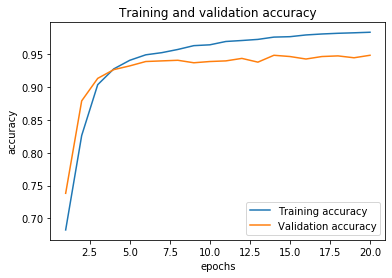

In [15]:
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, validation_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

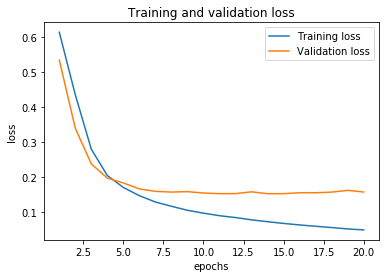

In [16]:
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, validation_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

## Make predictions

In [17]:
def predict(text):
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=MAX_LEN)
    score = model.predict([x_test])[0]
    return score

In [18]:
predict("Did you hear about the claustrophobic astronaut? He just needed a little space.")

array([0.99967253], dtype=float32)

In [19]:
predict("Law is commonly understood as a system of rules that are created and" 
        "enforced through social or governmental institutions to regulate conduct")

array([0.08738839], dtype=float32)